# Optimising the parameters of ball-and-stick model

This tutorial will explain how to search for parameters of ball-and-stick model.

This tutorial will consist of the following parts:
- *Setting up the cell model*
- *Creating a score calculator*
- *Running the parameter optimisation*
- *Analysing the results*

Let's load matplotlib (plotting library) first:

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We **import BluePyOpt** and the submodule that contains all the functionality to create biophysiocally detailed electrical cell models

In [7]:
import bluepyopt as bpop
import bluepyopt.ephys as ephys

Setting up the cell model
-------------------------
First a template that will describe the cell has to be defined. A template consists of:
* the shape of the cell (morphology)
* the description (equations) of the ion channels on the membrane (mechanisms)
* the parameters of the model

### Adding a morphology
The shape of a neuron is loaded from a file (SWC or ASC format). Below you can see an SWC description of a morphology with a soma with a radius of 10 micron, and a single dendritic section with a length of 100 micron and a radius of 2 micron. Let's write this to a file so that we can load it in [BluePyOpt](https://github.com/BlueBrain/BluePyOpt).

In [8]:
# Link to 'some' specification'

morph_swc_string = """
1 1 0.0 -10.0 0.0 10.0 -1                                                        
2 1 0.0 0.0 0.0 10.0 1                                                           
3 1 0.0 10.0 0.0 10.0 2                                                          
4 3 0.0 10.0 0.0 2.0 1                                                           
5 3 0.0 110.0 0.0 2.0 4
"""
with open('ballandstick.swc', 'w') as swc_file:
    swc_file.write(morph_swc_string)

We can plot this morphology using [NeuroM](https://github.com/BlueBrain/NeuroM)

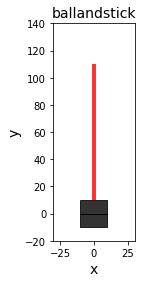

In [9]:
import neurom
import neurom.viewer
fig, ax = neurom.viewer.draw(neurom.load_neuron('ballandstick.swc'), outline=False)

To use this morphology in BluePyOpt we create a NrnFileMorphology object

In [10]:
morph = ephys.morphologies.NrnFileMorphology('ballandstick.swc')

By default a Neuron morphology has the following section lists: somatic, axonal, apical and basal. Let's Location objects that point to the somatic and basal sectionlist. This object will be used later to specify where mechanisms have to be added etc.

In [11]:
# Explain 'basal' (could also explain 'apical' 'axonal')
somatic_loc = ephys.locations.NrnSeclistLocation('somatic', seclist_name='somatic')
basal_loc = ephys.locations.NrnSeclistLocation('basal', seclist_name='basal')

### Creating a mechanism

Now we need to specify which ion channels are present on the membrane of this morphology. The NEURON simulator has a builtin implementation of th [Hodgkin-Huxley](https://en.wikipedia.org/wiki/Hodgkin–Huxley_model) Sodium (Na), Potassium (K) and leak channels. Let's add this mechanism (called 'hh') to the soma. 

The 'name' field can be chosen by the user, this name should be unique. The 'suffix' points to the same [field](https://www.neuron.yale.edu/neuron/static/new_doc/modelspec/programmatic/mechanisms/nmodl2.html#suffix) in the NMODL file of the channel. 'locations' specifies which sections the mechanism will be added to.

In [12]:
# Explain 'name'
# Explain suffix -> choice corresponds to 'insert' of NEURON

hh_mech = ephys.mechanisms.NrnMODMechanism(
        name='hh',
        suffix='hh',
        locations=[somatic_loc])


### Creating parameters

Next we need to specify the parameters of the model. A parameter can be in two states: frozen and not-frozen. When a parameter is frozen it has an exact value, otherwise it only has some bounds but the exact value is not known yet.
Let's define first a parameter that sets the specific capacitance of the soma to a frozen value

In [13]:
# Put units everywhere
# Explain section parameter

cm_param = ephys.parameters.NrnSectionParameter(
        name='cm',
        param_name='cm',
        value=1.0,
        locations=[somatic_loc],
        frozen=True)

And parameters that represent the maximal conductance of the sodium and potassium channels. These two parameters will be optimised later.

In [15]:
gnabar_param = ephys.parameters.NrnSectionParameter(                                    
        name='gnabar_hh',
        param_name='gnabar_hh',
        locations=[somatic_loc],
        bounds=[0.05, 0.125],
        frozen=False)     
gkbar_param = ephys.parameters.NrnSectionParameter(
        name='gkbar_hh',
        param_name='gkbar_hh',
        bounds=[0.01, 0.05],
        locations=[somatic_loc],
        frozen=False)

### Creating the cell model

We put all the components (morphology, mechanisms, parameters) together into a CellModel.

In [16]:
ballandstick_cell = ephys.models.CellModel(
        name='simple_cell',
        morph=morph,
        mechs=[hh_mech],
        params=[cm_param, gnabar_param, gkbar_param])  

We can print out a description of the neuron

In [17]:
print(ballandstick_cell)

simple_cell:
  morphology:
    ballandstick.swc
  mechanisms:
    hh: hh at ['somatic']
  params:
    cm: ['somatic'] cm = 1.0
    gnabar_hh: ['somatic'] gnabar_hh = [0.05, 0.125]
    gkbar_hh: ['somatic'] gkbar_hh = [0.01, 0.05]



With this cell we can build a cell evaluator.

## Setting up a cell evaluator

To optimise the parameters of the cell we need to create an object that will translate parameter values into fitness scores.

This object will need to know which protocols to inject, which parameters to optimise, etc.

### Creating the protocols

A protocol consists of a set of stimuli, and a set of responses (i.e. recordings). These responses will later be used to calculate
the score of the parameter values.
Let's create two protocols, two square current pulses at somatic`[0]`(0.5) with different amplitudes.
We first need to create a location object

In [18]:
soma_loc = ephys.locations.NrnSeclistCompLocation(
        name='soma',
        seclist_name='somatic',
        sec_index=0,
        comp_x=0.5)


and then the stimuli, recordings and protocols. For each protocol we add a recording and a stimulus in the soma.

In [19]:
sweep_protocols = []
for protocol_name, amplitude in [('step1', 0.1), ('step2', 0.5)]:
    
    # Refer to IClamp from other tutorial
    stim = ephys.stimuli.NrnSquarePulse(
                step_amplitude=amplitude,
                step_delay=100,
                step_duration=50,
                location=soma_loc,
                total_duration=200)
    rec = ephys.recordings.CompRecording(
            name='%s.soma.v' % protocol_name,
            location=soma_loc,
            variable='v')
    protocol = ephys.protocols.SweepProtocol(protocol_name, [stim], [rec])
    sweep_protocols.append(protocol)
twostep_protocol = ephys.protocols.SequenceProtocol('twostep', protocols=sweep_protocols)

### Running a protocol on a cell

Now we're at a stage where we can actually run a protocol on the cell. We first need to create a Simulator object (an abstraction of the NEURON simulator).

In [20]:
# Put reference to documentation of every class

nrn = ephys.simulators.NrnSimulator()

The run() method of a protocol accepts a cell model, a set of parameter values and a simulator

In [28]:
default_params = {'gnabar_hh': 0.1, 'gkbar_hh': 0.03}

# Running without value won't work
responses = twostep_protocol.run(cell_model=ballandstick_cell, param_values=default_params, sim=nrn)

Plotting the response traces is now easy:

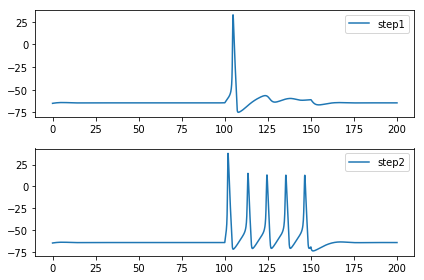

In [24]:
def plot_responses(responses):
    plt.subplot(2,1,1)
    plt.plot(responses['step1.soma.v']['time'], responses['step1.soma.v']['voltage'], label='step1')
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(responses['step2.soma.v']['time'], responses['step2.soma.v']['voltage'], label='step2')
    plt.legend()
    plt.tight_layout()

plot_responses(responses)

As you can see, when we use different parameter values, the response looks different.

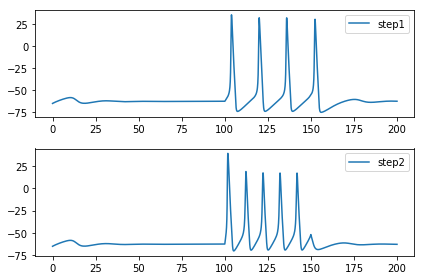

In [33]:
other_params = {'gnabar_hh': 0.1, 'gkbar_hh': 0.02}
plot_responses(twostep_protocol.run(cell_model=ballandstick_cell, param_values=other_params, sim=nrn))

# Exercise 1:

Try to find a value of gkbar_hh (within bounds) that produces 4 spikes in the first trace and 5 traces the second (solution=0.02). (Don't change gnabar_hh).

### Defining eFeatures and objectives

Instead of visually inspecting the traces, we can make use of eFEL (eFeature Extraction Library) to analyse the traces for us. This library can e.g. calculate the number of spikes in a trace, the height of these spikes, etc.

Number of spikes in 2nd trace: [5]
Spike widths (ms) in 2nd trace: [ 1.7  1.3  1.2  1.3  1.3]
Spike heights (mV) in 2nd trace: [ 100.47515715   62.17525137   60.4150889    59.76129548   60.35089436]


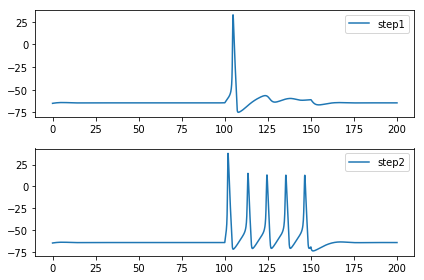

In [35]:
responses = twostep_protocol.run(cell_model=ballandstick_cell, param_values=default_params, sim=nrn)
# show where these names come from
step2_time = responses['step2.soma.v']['time']
step2_voltage = responses['step2.soma.v']['voltage']

# Define this dictionary
trace = {'T': step2_time, 'V': step2_voltage, 'stim_start': [100], 'stim_end': [150]}

import efel
# Explain AP_width (from where to where is AP_amplitude...
feature_values = efel.getFeatureValues([trace], ['Spikecount', 'AP_width', 'AP_amplitude'])[0]

plot_responses(responses)
print 'Number of spikes in 2nd trace: %s' % feature_values['Spikecount']
print 'Spike widths (ms) in 2nd trace: %s' % feature_values['AP_width']
print 'Spike amplitude (mV) in 2nd trace: %s' % feature_values['AP_amplitude']

Now we will, for every response, define a set of eFeatures we will use for the fitness calculation later. Let's use the SpikeCount feature: the first trace should have 1 spike, the second trace 5.

Different features can be combined together into objectives that will be used by the optimisation algorithm. In this case we will create one objective per feature.

Let's first set our goal. Let's ask for 1 spike in the first trace, and 6 spikes in the second trace:

In [37]:
efel_feature_means = {'step1': {'Spikecount': 4}, 'step2': {'Spikecount': 5}}

And then we define the eFELFeature and Objective objects:

In [38]:
objectives = []
features = []

for protocol in sweep_protocols:
    stim_start = protocol.stimuli[0].step_delay
    stim_end = stim_start + protocol.stimuli[0].step_duration
    for efel_feature_name, mean in efel_feature_means[protocol.name].items():
        feature_name = '%s.%s' % (protocol.name, efel_feature_name)
        feature = ephys.efeatures.eFELFeature(
                    feature_name,
                    efel_feature_name=efel_feature_name,
                    recording_names={'': '%s.soma.v' % protocol.name},
                    stim_start=stim_start,
                    stim_end=stim_end,
                    exp_mean=mean,
                    exp_std=0.05 * abs(mean))
        features.append(feature)
        objective = ephys.objectives.SingletonObjective(
            feature_name,
            feature)
        objectives.append(objective)

### Creating the cell evaluator

We will need an object that can use these objective definitions to calculate the scores from a protocol response. This is called a ScoreCalculator.

In [39]:
score_calc = ephys.objectivescalculators.ObjectivesCalculator(objectives) 

Combining everything together we have a CellEvaluator. The CellEvaluator constructor has a field 'parameter_names' which contains the (ordered) list of names of the parameters that are used as input (and will be fitted later on).

In [40]:
cell_evaluator = ephys.evaluators.CellEvaluator(
        cell_model=ballandstick_cell,
        param_names=['gnabar_hh', 'gkbar_hh'],
        fitness_protocols={twostep_protocol.name: twostep_protocol},
        fitness_calculator=score_calc,
        sim=nrn)


### Evaluating the cell

Now we can ask evaluator to calculate the scores for a set of parameters. (The lower the score the better the model). Let's calculate the score of the default_params set we used before, we know that this parameter set generates 1 spike in the first trace, and 5 spikes in the second, so we know that this should generate a perfect score of 0 for step1. For step2 we are searching for a solution with 6 spikes, so the score of our default_params won't be perfect for that trace:

In [41]:
# Explain '15'

print 'Scores:', cell_evaluator.evaluate_with_dicts(default_params)

Scores:

 {'step2.Spikecount': 0.0, 'step1.Spikecount': 15.0}


## Setting up and running an optimisation

As you might have seen in Exercise 1, it's not always trivial to find a parameter value set that matches the objectives. Let's now use the BluePyOpt parameter optimisation algorithm to find a set of parameter values that generates a perfect score of 0 on both traces.

The [evolutionary algorithm](https://en.wikipedia.org/wiki/Evolutionary_algorithm) used by BluePyOpt will sequentially generate of population of individual parameter sets (generations). In every generation a set of parents is selected from the previous population. These parents are used to generate an offspring, and a new population is created based on parents and offspring.

Let us specify that we want to have an offspring size of 10 individuals. This means every population will have 20 individuals (10 parents, 10 offspring).

In [42]:
optimisation_algorithm = bpop.deapext.optimisations.IBEADEAPOptimisation(
        evaluator=cell_evaluator,
        offspring_size = 10)

Now the optimisation algorithm can be run for a certain number of generations.

**Executing the next cell will take some time (a minute or so). There will be a ['*'] shown next to line while it is running.** 

In [43]:
# Explain better hall_of_fame etc.

final_pop, hall_of_fame, logs, hist = optimisation_algorithm.run(max_ngen=10)

The optimisation has return us 4 objects: final population, hall of fame, statistical logs and history. 

The final population contains a list of tuples, with each tuple representing the two parameters of the model

In [44]:
# Pretty print ?
print('Final population: ', final_pop)

('Final population: ', [[0.11480287814868599, 0.0222784106458639], [0.11501383044283107, 0.02233162478035977], [0.11501383044283107, 0.02233162478035977], [0.11501383044283107, 0.02233162478035977], [0.11480287814868599, 0.0222784106458639], [0.11501383044283107, 0.02233162478035977], [0.11356998178355383, 0.022359794400029644], [0.11501383044283107, 0.02233162478035977], [0.11481124827254321, 0.0222784106458639], [0.11501383044283107, 0.02820669755776245], [0.08869789340527853, 0.02478085383341757], [0.08667984764868178, 0.02477525832122627], [0.08869789340527853, 0.02477525832122627], [0.11480287814868599, 0.03229593057829689], [0.08550349130934805, 0.02477525832122627], [0.08817007717290132, 0.02477525832122627], [0.08311523855476341, 0.02478085383341757], [0.1155390517340846, 0.02233162478035977], [0.11665190944534751, 0.02233162478035977], [0.11501383044283107, 0.02057791385060121]])


The best individual found during the optimisation is the first individual of the hall of fame

In [45]:
best_ind = hall_of_fame[0]
print('Best individual: ', best_ind)

('Best individual: ', [0.11481124827254321, 0.0222784106458639])


We can evaluate this individual and make use of a convenience function of the cell evaluator to return us a dictionary of the scores.

In [49]:
best_ind_dict = cell_evaluator.param_dict(best_ind)
print best_ind_dict

{'gnabar_hh': 0.11481124827254321, 'gkbar_hh': 0.0222784106458639}


As you can see the evaluation returns the same values as the fitness values provided by the optimisation output. 
We can have a look at the responses now.

Score:  {'step2.Spikecount': 0.0, 'step1.Spikecount': 0.0}


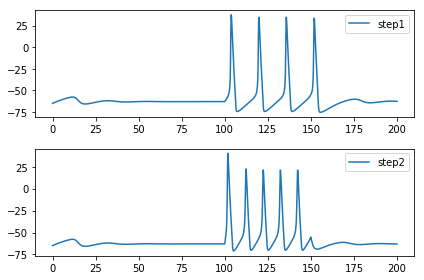

In [52]:
responses = twostep_protocol.run(cell_model=ballandstick_cell, param_values=best_ind_dict, sim=nrn)
print "Score: ", score_calc.calculate_scores(responses)
plot_responses(responses)
 

And indeed, as requested, the algorithm found a solution with 4 spikes in step1 and 5 spikes in step2

Let's have a look at the optimisation algorithm statistics.
We can plot the minimal score (sum of all objective scores) found in every generation. 

(0.0, 5.5)

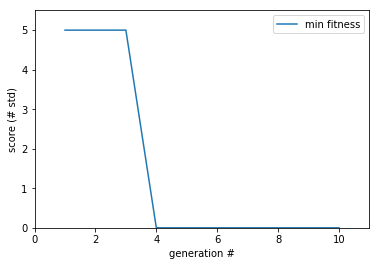

In [53]:
import numpy
gen_numbers = logs.select('gen')
min_fitness = logs.select('min')
max_fitness = logs.select('max')
plt.plot(gen_numbers, min_fitness, label='min fitness')
plt.xlabel('generation #')
plt.ylabel('score (# std)')
plt.legend()
plt.xlim(min(gen_numbers) - 1, max(gen_numbers) + 1) 
plt.ylim(0.9*min(min_fitness), 1.1 * max(min_fitness)) 

# Exercise 2:

Below is a copy of some of the above statements. Every variable has '\_ex' as suffix to prevent clashes with the code above.

Change the code in such a way that instead of the Spikecount feature, we search for a solution with AP_width of 1.3 in step1 and AP_width of 1.6 in step2.

Send us back the scores of the best individual found by the algorithm

('Best individual: ', [0.11481124827254321, 0.0222784106458639])
[0.0, 0.0]


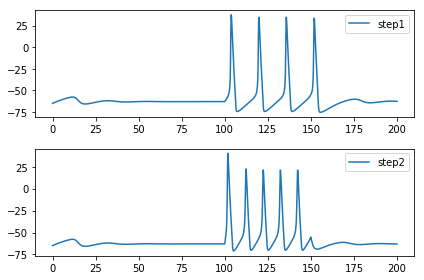

In [54]:
efel_feature_means_ex = {'step1': {'Spikecount': 4}, 'step2': {'Spikecount': 5}}
# efel_feature_means_ex = {'step1': {'AP_width': 1.3}, 'step2': {'AP_width': 1.6}} # solution
objectives_ex = []
features_ex = []

for protocol in sweep_protocols:
    stim_start = protocol.stimuli[0].step_delay
    stim_end = stim_start + protocol.stimuli[0].step_duration
    for efel_feature_name, mean in efel_feature_means_ex[protocol.name].items():
        feature_name = '%s.%s' % (protocol.name, efel_feature_name)
        feature = ephys.efeatures.eFELFeature(
                    feature_name,
                    efel_feature_name=efel_feature_name,
                    recording_names={'': '%s.soma.v' % protocol.name},
                    stim_start=stim_start,
                    stim_end=stim_end,
                    exp_mean=mean,
                    exp_std=0.05 * mean)
        features_ex.append(feature)
        objective = ephys.objectives.SingletonObjective(
            feature_name,
            feature)
        objectives_ex.append(objective)
        
score_calc_ex = ephys.objectivescalculators.ObjectivesCalculator(objectives_ex)

cell_evaluator_ex = ephys.evaluators.CellEvaluator(
        cell_model=ballandstick_cell,
        param_names=['gnabar_hh', 'gkbar_hh'],
        fitness_protocols={twostep_protocol.name: twostep_protocol},
        fitness_calculator=score_calc_ex,
        sim=nrn)

optimisation_algorithm_ex = bpop.deapext.optimisations.IBEADEAPOptimisation(
        evaluator=cell_evaluator_ex,
        offspring_size = 10)

final_pop_ex, hall_of_fame_ex, logs_ex, hist_ex = optimisation_algorithm_ex.run(max_ngen=10)

best_ind_ex = hall_of_fame_ex[0]
print('Best individual: ', best_ind_ex)

best_ind_dict_ex = cell_evaluator.param_dict(best_ind_ex)
print(cell_evaluator_ex.evaluate_with_lists(best_ind_ex))

plot_responses(twostep_protocol.run(cell_model=ballandstick_cell, param_values=best_ind_dict_ex, sim=nrn))